In [9]:
import torch
import torch.nn as nn
from torch.nn import Sequential as Seq,Linear,ReLU,BatchNorm1d
from torch_scatter import scatter_mean

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from InteractionNetwork import InteractionNetwork

In [10]:
import numpy

<hr>
load pretrained model

In [11]:
model=InteractionNetwork()
model.load_state_dict(torch.load("../data/model/IN_best_dec10.pth",map_location=torch.device('cpu')))

<All keys matched successfully>

end of load pretrained model
<hr>
get data

In [12]:
# get data

import yaml
from GraphDataset import GraphDataset


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



with open('../data/definitions.yml') as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    definitions = yaml.load(file, Loader=yaml.FullLoader)
    
features = definitions['features']
spectators = definitions['spectators']
labels = definitions['labels']

nfeatures = definitions['nfeatures']
nspectators = definitions['nspectators']
nlabels = definitions['nlabels']
ntracks = definitions['ntracks']


file_names=["/teams/DSC180A_FA20_A00/b06particlephysics/train/ntuple_merged_10.root"]
graph_dataset = GraphDataset('../data', features, labels, spectators, n_events=10000, n_events_merge=1000, 
                             file_names=file_names)

In [13]:
b=graph_dataset[0]
g=b[1]
g.batch=torch.tensor(np.zeros(g.x.shape[0]).astype("int64"))
g

Data(batch=[18], edge_index=[2, 306], u=[1, 2], x=[18, 48], y=[1, 2])

In [14]:
row,col=g.edge_index

In [15]:
g.y

tensor([[0, 1]])

end of get data<hr>

functions copied from `src.util`

In [16]:
def copy_layer(layer):
    """
    create a deep copy of provided layer
    """
    layer_cp=eval("nn."+layer.__repr__())
    layer_cp.load_state_dict(layer.state_dict())
    
    return layer_cp

In [17]:
copy_tensor=lambda x: torch.tensor(x.clone().detach().numpy(),requires_grad=True,dtype=torch.float32)

In [18]:
L=dict()
hook_handles=[]
A=dict()
C=dict()


# def make_backward_hook(name):
#     def get_grad(grad):
#         C[name]=grad.data
        
#         return grad
#     return make_backward_hook


def make_forward_hook(name):
    def get_activations(self,inputs,outputs):
        assert len(inputs)==1
        inputs=inputs[0]
#         inputs.retain_grad()
#         hook=make_backward_hook(name)
#         hook_handles.append(inputs.register_hook(hook))
        
        A[name]=copy_tensor(inputs)
        
    return get_activations



def get_layers(name,model):
    l=list(model.named_children())
    
    if len(l)==0:
        L[name]=model
        hook=make_forward_hook(name)
        hook_handles.append(model.register_forward_hook(hook))
    else:
        l=list(model.named_children())
        for i in l:
            get_layers(name+"."+i[0],i[1])

[h.remove() for h in hook_handles]
get_layers("",model)

In [19]:
model.eval()
u=model.forward(g.x,g.edge_index,g.batch)
u

tensor([[-0.8977,  1.5272]], grad_fn=<AddmmBackward>)

In [20]:
_A={}

for i,n in enumerate(A.keys()):
    print(i,n,A[n].shape)
    _A[i]=A[n]

0 .bn torch.Size([18, 48])
1 .interactionnetwork.edge_model.edge_mlp.0 torch.Size([306, 96])
2 .interactionnetwork.edge_model.edge_mlp.1 torch.Size([306, 128])
3 .interactionnetwork.edge_model.edge_mlp.2 torch.Size([306, 128])
4 .interactionnetwork.edge_model.edge_mlp.3 torch.Size([306, 128])
5 .interactionnetwork.node_model.node_mlp_1.0 torch.Size([306, 176])
6 .interactionnetwork.node_model.node_mlp_1.1 torch.Size([306, 128])
7 .interactionnetwork.node_model.node_mlp_1.2 torch.Size([306, 128])
8 .interactionnetwork.node_model.node_mlp_1.3 torch.Size([306, 128])
9 .interactionnetwork.node_model.node_mlp_2.0 torch.Size([18, 176])
10 .interactionnetwork.node_model.node_mlp_2.1 torch.Size([18, 128])
11 .interactionnetwork.node_model.node_mlp_2.2 torch.Size([18, 128])
12 .interactionnetwork.node_model.node_mlp_2.3 torch.Size([18, 128])
13 .interactionnetwork.global_model.global_mlp.0 torch.Size([1, 128])
14 .interactionnetwork.global_model.global_mlp.1 torch.Size([1, 128])
15 .interaction

In [21]:
pred=nn.Softmax(dim=1)(u)
r={}
# r[17]=copy_tensor(pred)
r[17]=copy_tensor(u*torch.tensor([0,1],dtype=torch.float32))
r[17]

tensor([[-0.0000, 1.5272]], requires_grad=True)

In [120]:
a=copy_tensor(_A[16])
a.retain_grad()
layer=L[".interactionnetwork.global_model.global_mlp.3"]

z=layer.forward(a)
s=r[17]/(z+1e-9)

(z*s.data).sum().backward()

c=a.grad
r[16]=a*c

In [23]:
r[16].sum()

tensor(1.4595, grad_fn=<SumBackward0>)

In [139]:
a=copy_tensor(_A[16])
w=L[".interactionnetwork.global_model.global_mlp.3"].weight
b=L[".interactionnetwork.global_model.global_mlp.3"].bias
rk=r[17]

In [145]:
a@w.T+b

tensor([[-0.8977,  1.5272]], grad_fn=<AddBackward0>)

In [149]:
sum(a[0]*w[0,:])

tensor(-0.8981, grad_fn=<AddBackward0>)

In [132]:
def epsilon_rule(a,w,b,R,epsilon=1e-9):
    result=torch.zeros(*a.shape)
    n=torch.zeros(*a.shape)
    d=torch.zeros(*a.shape)
    for j in range(result.shape[0]):
        for k in range(result.shape[1]):
            n[j,k]=a[j]*w[j,k]
    
    for j in range(result.shape[0]):
        for k in range(result.shape[1]):
            d

epsilon_rule(copy_tensor(_A[16]),
             L[".interactionnetwork.global_model.global_mlp.3"].weight,
             L[".interactionnetwork.global_model.global_mlp.3"].bias,
            r[17])

RuntimeError: The expanded size of the tensor (128) must match the existing size (2) at non-singleton dimension 0.  Target sizes: [128].  Tensor sizes: [2]

In [24]:
a=copy_tensor(_A[15])
a.retain_grad()
layer=L[".interactionnetwork.global_model.global_mlp.2"]

z=layer.forward(a)
s=r[16]/(z+1e-9)

(z*s.data).sum().backward()

c=a.grad
r[15]=a*c

In [25]:
r[15].sum()

tensor(1.4595, grad_fn=<SumBackward0>)

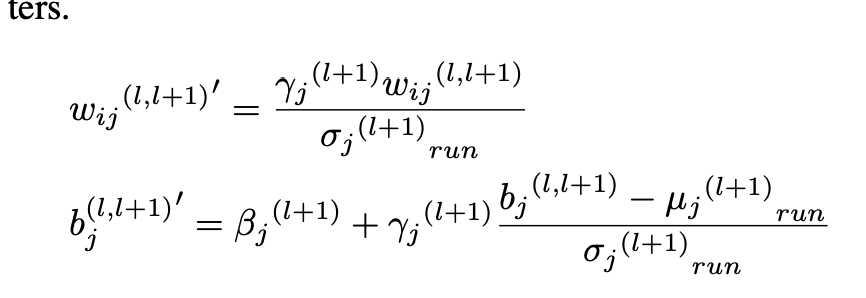

In [38]:
# w=copy_tensor(L[".interactionnetwork.global_model.global_mlp.0"].weight.data)
# b=copy_tensor(L[".interactionnetwork.global_model.global_mlp.0"].bias.data)

# gamma=copy_tensor(L[".interactionnetwork.global_model.global_mlp.1"].weight.data)
# beta=copy_tensor(L[".interactionnetwork.global_model.global_mlp.1"].bias.data)

# sigma=copy_tensor(((L[".interactionnetwork.global_model.global_mlp.1"].running_var+1e-5)**0.5).data)
# miu=copy_tensor((L[".interactionnetwork.global_model.global_mlp.1"].running_mean).data)

# layer=Linear(in_features=128,out_features=128)
# state=layer.state_dict()

# state["weight"]=copy_tensor(
#     (w.T*gamma/sigma).T
# ).data
# state["bias"]=copy_tensor(beta+gamma*(b-miu)/sigma).data

# layer.load_state_dict(state)


# a=copy_tensor(A[".interactionnetwork.global_model.global_mlp.0"].data)
# a.retain_grad()

# z=layer.forward(a)
# s=r[15]/(z+1e-9)

# (z*s.data).sum().backward()

# c=a.grad

# r[13]=a*c
# (r[13]).sum()

tensor(0.7613, grad_fn=<SumBackward0>)

|z|-rule for batchnorm layer

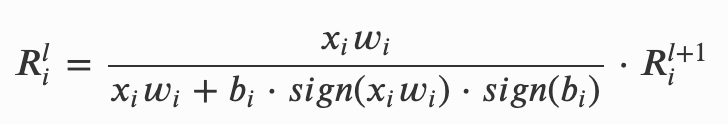

In [103]:
def f(X,Rk):
    Ri=torch.zeros(*X.shape)
    for i in range(X.shape[0]):
        x=X[i,:]
        n=x*w
        d=x*w+torch.abs(b)*torch.sign(x*w)
        Ri[i,:]=(n/d)*Rk[i,:]
        
    return Ri

w=copy_tensor(L[".interactionnetwork.global_model.global_mlp.1"].weight.data)
b=copy_tensor(L[".interactionnetwork.global_model.global_mlp.1"].bias.data)
a=copy_tensor(A[".interactionnetwork.global_model.global_mlp.1"].data)

result=f(a,r[15])
result.sum()

tensor(1.2344, grad_fn=<SumBackward0>)

In [104]:
w=copy_tensor(L[".interactionnetwork.global_model.global_mlp.1"].weight.data)
b=copy_tensor(L[".interactionnetwork.global_model.global_mlp.1"].bias.data)


def f(x):
    x.retain_grad()
    
    n=x*w
    d=n+b*torch.sign(n)*torch.sign(b)
    
    return n/d


a=copy_tensor(A[".interactionnetwork.global_model.global_mlp.1"].data)
frac=f(a)
r[14]=frac*r[15]

print(r[14].sum())




a=copy_tensor(A[".interactionnetwork.global_model.global_mlp.0"])
a.retain_grad()
layer=L[".interactionnetwork.global_model.global_mlp.0"]

z=layer.forward(a)
s=r[14]/(z+1e-9)

(z*s.data).sum().backward()

c=a.grad
r[13]=a*c

print(r[13].sum())

tensor(1.2344, grad_fn=<SumBackward0>)
tensor(1.0772, grad_fn=<SumBackward0>)


In [105]:
n_tracks=g.x.shape[0]
r_scatter=r[13].repeat(n_tracks,1)/n_tracks
r_scatter.sum()

tensor(1.0772, grad_fn=<SumBackward0>)

In [106]:
n_tracks=g.x.shape[0]
r_scatter=r[13].repeat(n_tracks,1)/n_tracks

a=copy_tensor(A[".interactionnetwork.node_model.node_mlp_2.3"])
a.retain_grad()
layer=L[".interactionnetwork.node_model.node_mlp_2.3"]

z=layer.forward(a)
s=r_scatter/(z+1e-9)

(z*s.data).sum().backward()

c=a.grad
r[12]=a*c

In [107]:
a=copy_tensor(A[".interactionnetwork.node_model.node_mlp_2.2"])
a.retain_grad()
layer=L[".interactionnetwork.node_model.node_mlp_2.2"]

z=layer.forward(a)
s=r[12]/(z+1e-9)

(z*s.data).sum().backward()

c=a.grad
r[11]=a*c

In [108]:
# w=copy_tensor(L[".interactionnetwork.node_model.node_mlp_2.0"].weight.data)
# b=copy_tensor(L[".interactionnetwork.node_model.node_mlp_2.0"].bias.data)

# gamma=copy_tensor(L[".interactionnetwork.node_model.node_mlp_2.1"].weight.data)
# beta=copy_tensor(L[".interactionnetwork.node_model.node_mlp_2.1"].bias.data)

# sigma=copy_tensor(((L[".interactionnetwork.node_model.node_mlp_2.1"].running_var+1e-5)**0.5).data)
# miu=copy_tensor((L[".interactionnetwork.node_model.node_mlp_2.1"].running_mean).data)

# layer=Linear(in_features=48+128,out_features=128)
# state=layer.state_dict()
# state["weight"]=copy_tensor(
#     (w.T*gamma/sigma).T
# ).data
# state["bias"]=copy_tensor(beta+gamma*(b-miu)/sigma).data
# layer.load_state_dict(state)


# a=copy_tensor(A[".interactionnetwork.node_model.node_mlp_2.0"].data)
# a.retain_grad()

# z=layer.forward(a)
# s=r[11]/(z+1e-9)

# (z*s.data).sum().backward()

# c=a.grad

# r[10]=a*c
# (r[10]).sum()

In [109]:
w=copy_tensor(L[".interactionnetwork.node_model.node_mlp_2.1"].weight.data)
b=copy_tensor(L[".interactionnetwork.node_model.node_mlp_2.1"].bias.data)


def f(x):
    x.retain_grad()
    
    n=x*w
    d=n+b*torch.sign(n)*torch.sign(b)
    
    return n/d


a=copy_tensor(A[".interactionnetwork.node_model.node_mlp_2.1"].data)
frac=f(a)
r[10]=frac*r[11]

print(r[10].sum())




a=copy_tensor(A[".interactionnetwork.node_model.node_mlp_2.0"])
a.retain_grad()
layer=L[".interactionnetwork.node_model.node_mlp_2.0"]

z=layer.forward(a)
s=r[10]/(z+1e-9)

(z*s.data).sum().backward()

c=a.grad
r[9]=a*c

print(r[9].sum())

tensor(1.2505, grad_fn=<SumBackward0>)
tensor(0.9578, grad_fn=<SumBackward0>)


In [232]:
# r split to two paths
r_x,r_=r[9][:,:48],r[9][:,48:]
r_=r_[col]/(n_tracks-1)
print(r_.sum(),r_x.sum())

a=copy_tensor(A[".interactionnetwork.node_model.node_mlp_1.3"])
a.retain_grad()
layer=L[".interactionnetwork.node_model.node_mlp_1.3"]

z=layer.forward(a)
s=r_/(z+1e-9)

(z*s.data).sum().backward()

c=a.grad
r[8]=a*c

print(r[8].sum())

tensor(0.5208, grad_fn=<SumBackward0>) tensor(0.4369, grad_fn=<SumBackward0>)
tensor(2.5167, grad_fn=<SumBackward0>)


In [196]:
a=copy_tensor(A[".interactionnetwork.node_model.node_mlp_1.2"])
a.retain_grad()
layer=L[".interactionnetwork.node_model.node_mlp_1.2"]

z=layer.forward(a)
s=r[8]/(z+1e-9)

(z*s.data).sum().backward()

c=a.grad
r[7]=a*c

In [197]:
# w=copy_tensor(L[".interactionnetwork.node_model.node_mlp_1.0"].weight.data)
# b=copy_tensor(L[".interactionnetwork.node_model.node_mlp_1.0"].bias.data)

# gamma=copy_tensor(L[".interactionnetwork.node_model.node_mlp_1.1"].weight.data)
# beta=copy_tensor(L[".interactionnetwork.node_model.node_mlp_1.1"].bias.data)

# sigma=copy_tensor(((L[".interactionnetwork.node_model.node_mlp_1.1"].running_var+1e-5)**0.5).data)
# miu=copy_tensor((L[".interactionnetwork.node_model.node_mlp_1.1"].running_mean).data)

# layer=Linear(in_features=48+128,out_features=128)
# state=layer.state_dict()
# state["weight"]=copy_tensor(
#     (w.T*gamma/sigma).T
# ).data
# state["bias"]=copy_tensor(beta+gamma*(b-miu)/sigma).data
# layer.load_state_dict(state)


# a=copy_tensor(A[".interactionnetwork.node_model.node_mlp_1.0"].data)
# a.retain_grad()

# z=layer.forward(a)
# s=r[7]/(z+1e-9)

# (z*s.data).sum().backward()

# c=a.grad

# r[6]=a*c

In [200]:
w=copy_tensor(L[".interactionnetwork.node_model.node_mlp_1.1"].weight.data)
b=copy_tensor(L[".interactionnetwork.node_model.node_mlp_1.1"].bias.data)


def f(x):
    x.retain_grad()
    
    n=x*w
    d=n+b*torch.sign(n)*torch.sign(b)
    
    return n/d


a=copy_tensor(A[".interactionnetwork.node_model.node_mlp_1.1"].data)
frac=f(a)
r[6]=frac*r[7]

print(r[6].sum())




a=copy_tensor(A[".interactionnetwork.node_model.node_mlp_1.0"])
a.retain_grad()
layer=L[".interactionnetwork.node_model.node_mlp_1.0"]

z=layer.forward(a)
s=r[6]/(z+1e-9)

(z*s.data).sum().backward()

c=a.grad
r[5]=a*c

print(r[5].sum())

tensor(-2.6654, grad_fn=<SumBackward0>)
tensor(-9.7315, grad_fn=<SumBackward0>)


In [204]:
# r split to two paths
r_x_row,r_=r[5][:,:48],r[5][:,48:]
print(r_.sum(),r_x_row.sum())

a=copy_tensor(A[".interactionnetwork.edge_model.edge_mlp.3"])
a.retain_grad()
layer=L[".interactionnetwork.edge_model.edge_mlp.3"]

z=layer.forward(a)
s=r_/(z+1e-9)

(z*s.data).sum().backward()

c=a.grad
r[4]=a*c

print(r[4].sum())

tensor(-110.2659, grad_fn=<SumBackward0>) tensor(100.5343, grad_fn=<SumBackward0>)
tensor(-112.6669, grad_fn=<SumBackward0>)


In [206]:
a=copy_tensor(A[".interactionnetwork.edge_model.edge_mlp.2"])
a.retain_grad()
layer=L[".interactionnetwork.edge_model.edge_mlp.2"]

z=layer.forward(a)
s=r[4]/(z+1e-9)

(z*s.data).sum().backward()

c=a.grad
r[3]=a*c

print(r[3].sum())

tensor(-112.6669, grad_fn=<SumBackward0>)


In [208]:
w=copy_tensor(L[".interactionnetwork.edge_model.edge_mlp.1"].weight.data)
b=copy_tensor(L[".interactionnetwork.edge_model.edge_mlp.1"].bias.data)


def f(x):
    x.retain_grad()
    
    n=x*w
    d=n+b*torch.sign(n)*torch.sign(b)
    
    return n/d


a=copy_tensor(A[".interactionnetwork.edge_model.edge_mlp.1"].data)
frac=f(a)
r[2]=frac*r[3]

print(r[2].sum())




a=copy_tensor(A[".interactionnetwork.edge_model.edge_mlp.0"])
a.retain_grad()
layer=L[".interactionnetwork.edge_model.edge_mlp.0"]

z=layer.forward(a)
s=r[2]/(z+1e-9)

(z*s.data).sum().backward()

c=a.grad
r[1]=a*c

print(r[1].sum())

tensor(-111.0026, grad_fn=<SumBackward0>)
tensor(-102.7765, grad_fn=<SumBackward0>)


In [234]:
r_src,r_dest=r[1][:,:48],r[1][:,48:]
r_x_src=scatter_mean(r_src,row,dim=0,dim_size=g.x.shape[0])
r_x_dest=scatter_mean(r_dest,col,dim=0,dim_size=g.x.shape[0])

w=copy_tensor(L[".bn"].weight.data)
b=copy_tensor(L[".bn"].bias.data)


def f(x):
    x.retain_grad()
    
    n=x*w
    d=n+b*torch.sign(n)*torch.sign(b)+1e-10
    
    return n/d


a=copy_tensor(A[".bn"].data)
frac=f(a)
r[0]=frac*(r_x_src+r_x_dest+r_x+scatter_mean(r_x_row,row,dim=0,dim_size=g.x.shape[0])+1e-10)
print(r[0].sum())

tensor(-1.1316, grad_fn=<SumBackward0>)


In [235]:
for i in range(17,0-1,-1):
    try:
        print(i,r[i].sum().data)
    except:
        continue

17 tensor(1.5272)
16 tensor(1.4595)
15 tensor(1.4595)
14 tensor(1.2344)
13 tensor(1.0772)
12 tensor(1.3492)
11 tensor(1.3492)
10 tensor(1.2505)
9 tensor(0.9578)
8 tensor(2.5167)
7 tensor(2.5167)
6 tensor(-2.6654)
5 tensor(-9.7315)
4 tensor(-112.6669)
3 tensor(-112.6669)
2 tensor(-111.0026)
1 tensor(-102.7765)
0 tensor(-1.1316)


<hr>

## Plot

In [238]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [239]:
sns.set(style="white")

In [250]:
sort_pt_idx=torch.argsort(g.x[:,0])

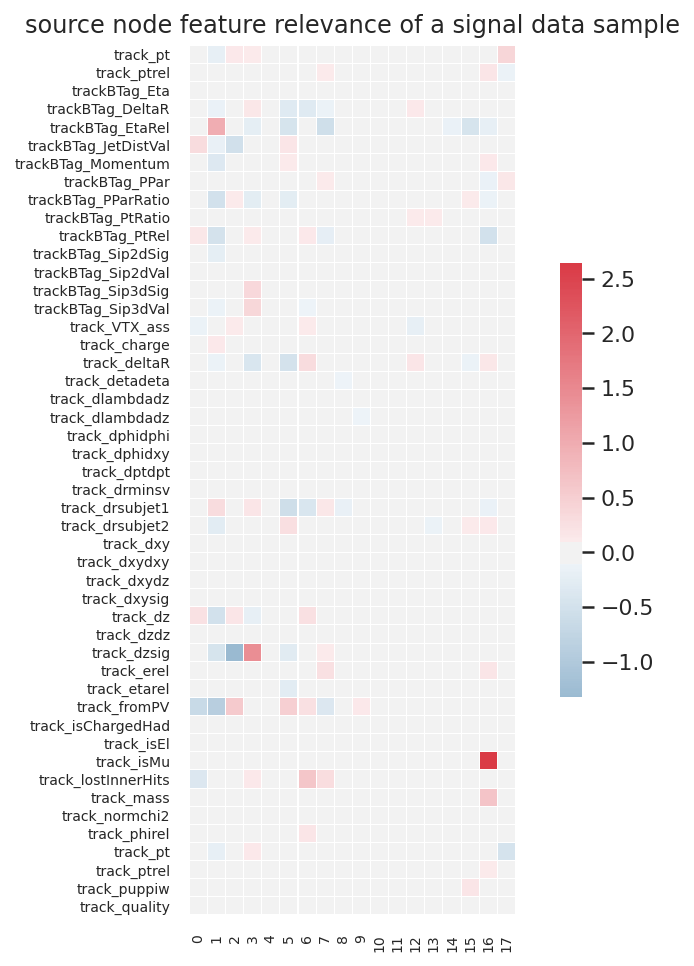

In [253]:
val=r[0].detach().cpu().numpy()
val=val[sort_pt_idx]
df=pd.DataFrame(val,columns=features).T

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8,8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
s=sns.heatmap(df, cmap=cmap, center=0,yticklabels=1,
            square=True, linewidths=0.01, cbar_kws={"shrink": .5})

s.tick_params(labelsize=7)

if g.y[:,1]>0:
    plt.title("source node feature relevance of a signal data sample")
else:
    plt.title("source node feature relevance of a background data sample")
plt.show()

<hr>

In [265]:
node_shade=np.linalg.norm(r[0].detach().numpy(),axis=1)
node_shade

array([1.8075725 , 1.0142772 , 0.8833184 , 0.24711034, 0.5374024 ,
       0.22022334, 1.2185864 , 0.07303815, 1.6707866 , 0.86539876,
       0.3583742 , 1.564374  , 0.6563535 , 0.10495465, 2.8245437 ,
       0.22842792, 0.12521288, 0.28466713], dtype=float32)

In [303]:
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from mpl_toolkits.mplot3d.axes3d import Axes3D
import networkx as nx
import matplotlib.colors as colors

In [304]:
def network_plot_3D(G, angle,label, edge_alpha,save=False):

    # Get node positions
    pos = nx.get_node_attributes(G, 'pos')
    node_shade=nx.get_node_attributes(G,"node_shade")
    
    # Get number of nodes
    n = G.number_of_nodes()

    # Get the maximum number of edges adjacent to a single node
#     edge_max = max([G.degree(i) for i in range(n)])

    # Define color range proportional to number of edges adjacent to a single node
#     colors = [plt.cm.plasma(G.degree(i)/edge_max) for i in range(n)] 

    # 3D network plot
    with plt.style.context(('ggplot')):
        
        fig = plt.figure(figsize=(10,7))
        ax = Axes3D(fig)
        
        # Loop on the pos dictionary to extract the x,y,z coordinates of each node
        for key, value in pos.items():
            xi = value[0]
            yi = value[1]
            zi = value[2]
            
            # Scatter plot
            ax.scatter(xi, yi, zi, c='k',s=25*node_shade[key], edgecolors='orange', alpha=0.5)
        
        # Loop on the list of edges to get the x,y,z, coordinates of the connected nodes
        # Those two points are the extrema of the line to be plotted
        weight=list(nx.get_edge_attributes(G, 'edge_shade').values())
        sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin=min(weight), vmax=max(weight)))
        for i,j in enumerate(G.edges()):

            x = np.array((pos[j[0]][0], pos[j[1]][0]))
            y = np.array((pos[j[0]][1], pos[j[1]][1]))
            z = np.array((pos[j[0]][2], pos[j[1]][2]))
        
        # Plot the connecting lines
            
#             ax.plot(x, y, z, c=sm.to_rgba(weight[i]), alpha=edge_alpha[i])
            ax.plot(x, y, z, c='b', alpha=edge_alpha[i])
    
    # Set the initial view
    ax.view_init(30, angle)

    # Hide the axes
#     ax.set_axis_off()
    plt.xlabel("track_etarel")
    plt.ylabel("track_phirel")
    plt.title(f"jet label: {label}")
    plt.show()

    plt.show()
    
    return

In [323]:
edge_shade=torch.norm(r_src+r_x_row,dim=1)
alpha=(edge_shade-edge_shade.min())/edge_shade.max()
alpha=alpha.detach().numpy()

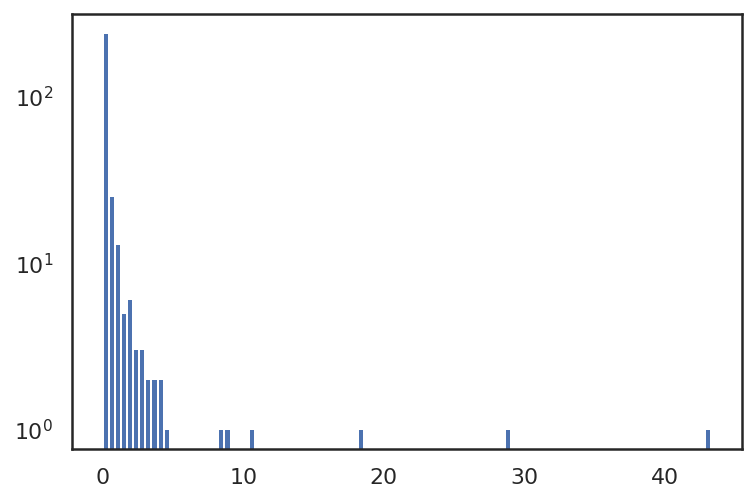

In [324]:
plt.hist(edge_shade.detach().numpy(),bins=100,log=True)
plt.show()

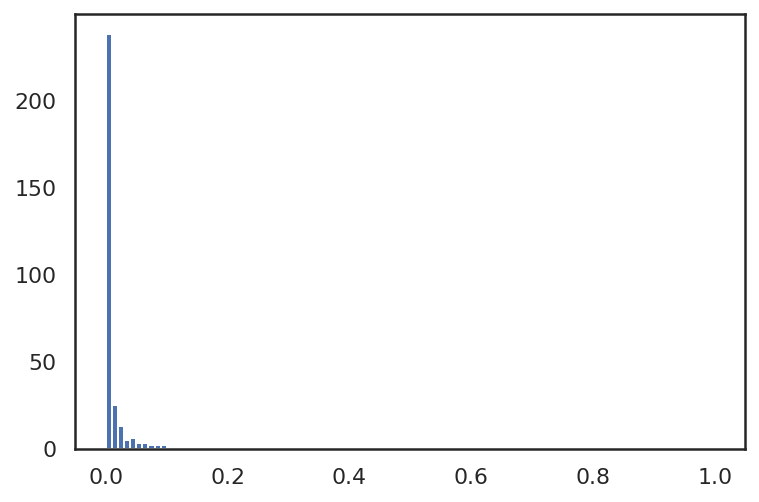

In [325]:
plt.hist(alpha,bins=100)
plt.show()

In [326]:
eta_idx=features.index("track_etarel")
phi_idx=features.index("track_phirel")

In [327]:
g.edge_shade=edge_shade
g.node_shade=node_shade

pos=np.array(list(zip(g.x[:,eta_idx].detach().numpy(),g.x[:,phi_idx].detach().numpy(),g.x[:,0].detach().numpy())))
g.pos=pos

In [328]:
from torch_geometric.utils import to_networkx

In [330]:
G = to_networkx(g, edge_attrs=['edge_shade'],node_attrs=["pos","node_shade"])

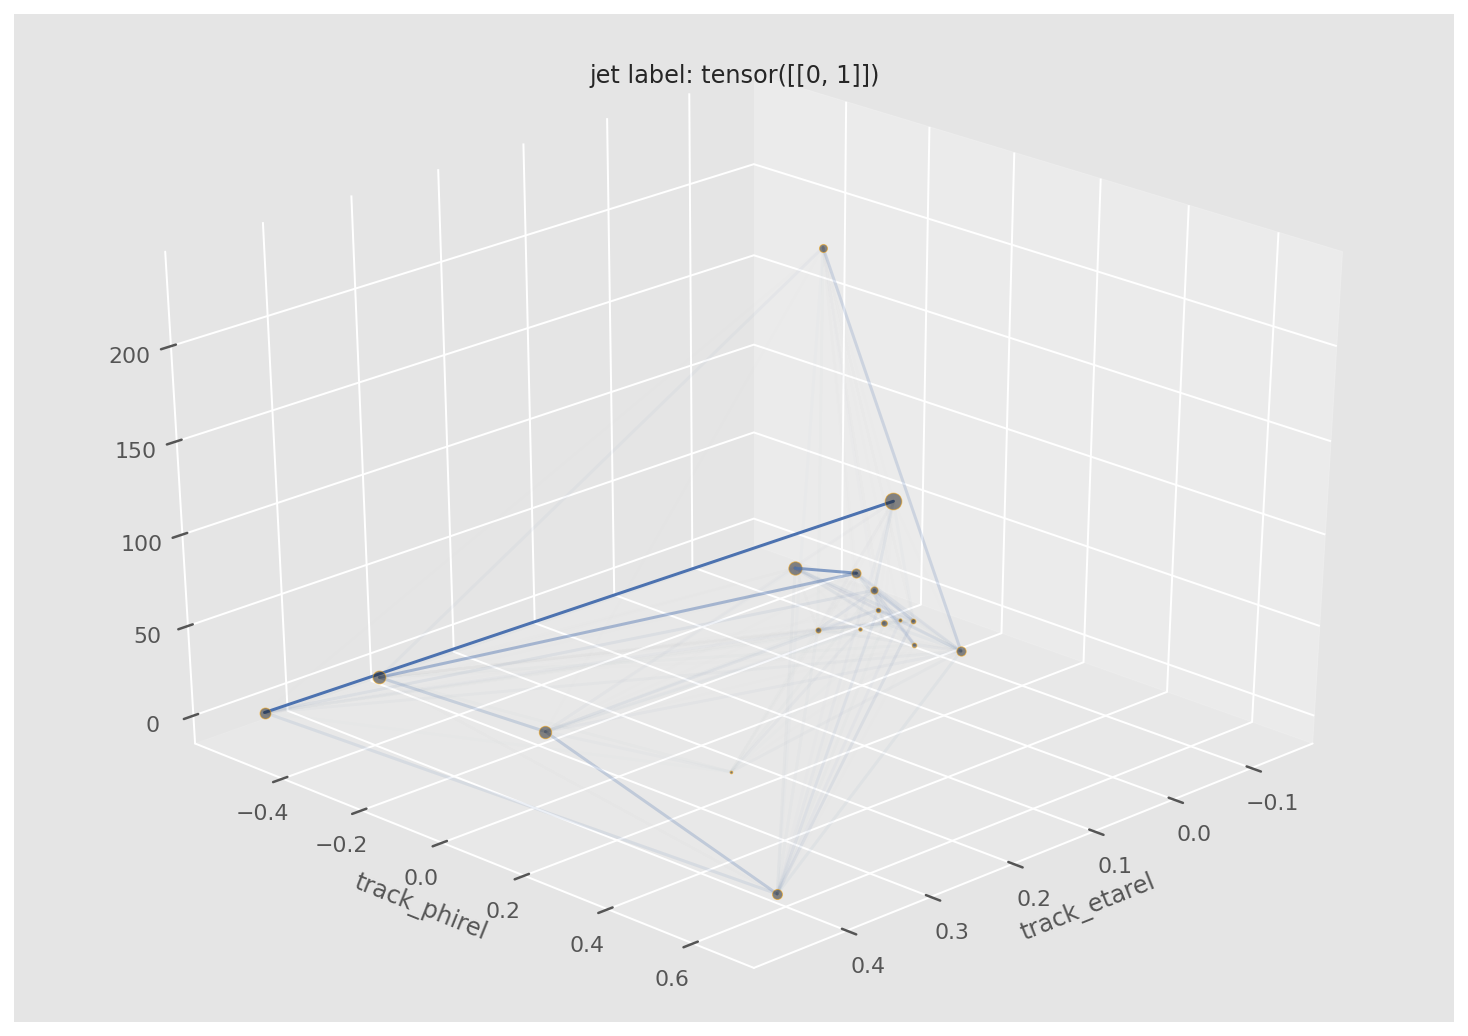

In [331]:
network_plot_3D(G,45,g.y.detach(),alpha)